# CA684 Machine Learning Assignment

## Table of Content:
* [Importing dependencies](#dependencies)
* [Evaluation function](#Evaluation)
* [Captions](#Captions)
   * [Pre processing](#prepro)
   * [Counter](#counter)
   * [Tokenizer](#tokenizer)
   * [Captions model creation](#capmod)
   * [Predictions](#pred1)
* [HMP](#hmp)
   * [Pre processing](#hmp)
   * [Model creation](#hmpmod)
   * [Prediction](#pred2)
* [C3D](#c3d)
   * [Pre processing](#c3d)
   * [Model creation](#c3dmod)
   * [Prediction](#pred3)
* [Ensemble 1](#ensemble1)
* [Combined model](#combmod)
   * [Predictions](#pred4)
* [Ensemble 2](#ensemble2)

* [Test Data](#test)
    * [Caption model prediction](#captest)
    * [HMP model prediction](#hmptest)
    * [C3D model prediction](#c3dtest)
    * [Combined model prediction](#combtest)
    * [Ensemble model prediction](#finsub)
    
* [Final Submission](#finsub)
   


## Importing Dependencies <a class="anchor" id="dependencies"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyprind
import glob
import os
from numpy.random import seed
seed(1)
from string import punctuation
from collections import Counter

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

In [3]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(1)
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


In [4]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to C:\Users\RANJAN
[nltk_data]     DAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Evaluation function <a class="anchor" id="Evaluation"></a>
Test data will be ranked based on Spearmann's correlation

In [6]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [7]:
def visualize(loss, val_loss, accuracy, val_accuracy):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'bv',label='Training loss')
    plt.plot(epochs,val_loss,'y',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()

    plt.plot(epochs, accuracy, 'bv', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'y', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Captions attribute <a class="anchor" id="Captions"></a>

#### Fetching grownd truth and captions

In [8]:
def get_data():
  train_ground_truth = pd.read_csv(r'C:\Users\RANJAN DAS\Video memorability\Train_set\Ground-truth\ground-truth.csv')
  train_ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1, inplace=True)

  train_captions = pd.read_csv(r'C:\Users\RANJAN DAS\Video memorability\Train_set\Captions\dev-set_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))
  
  test_ground_truth = pd.read_csv(r'C:\Users\RANJAN DAS\Video memorability\Test_set\Ground-truth_test\ground_truth_template.csv')
  test_ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'], axis=1, inplace=True)
  
  test_captions = pd.read_csv(r'C:\Users\RANJAN DAS\Video memorability\Test_set\Captions_test\test-set-1_video-captions.txt',delimiter='\t',header= None,names=('video','Captions'))
  
  return train_ground_truth, train_captions, test_ground_truth, test_captions

def videonameedit(dataframe):
    dataframe['video'] = dataframe['video'].apply(lambda x : x.split('.')[0])
    return dataframe

In [9]:
df, captions_features, df1, captions_features_test = get_data()

## Pre processing<a class="anchor" id="prepro"></a>
Converting data to standardised format

In [10]:
# removing extension from video name
df = videonameedit(df)
captions_features = videonameedit(captions_features)
captions_features_test = videonameedit(captions_features_test)

df.head()

,video,short-term_memorability,long-term_memorability
0,video3,0.924,0.846
1,video4,0.923,0.667
2,video6,0.863,0.700
3,video8,0.922,0.818
4,video10,0.950,0.900


In [11]:
print(df1.head())
df1['video'] = 'video' + df1['video'].astype(str)
print(df1.head())

   video  short-term_memorability  long-term_memorability
0   7494                      NaN                     NaN
1   7495                      NaN                     NaN
2   7496                      NaN                     NaN
3   7497                      NaN                     NaN
4   7498                      NaN                     NaN
       video  short-term_memorability  long-term_memorability
0  video7494                      NaN                     NaN
1  video7495                      NaN                     NaN
2  video7496                      NaN                     NaN
3  video7497                      NaN                     NaN
4  video7498                      NaN                     NaN


## Counter <a class="anchor" id="counter"></a>
Counter is a dict subclass for counting hashable objects. It is an unordered collection where elements
are stored as dictionary keys and their counts are stored as dictionary values.
We are using counter to create a key value pair of the word tokens and their number of occurence

In [12]:
counts = Counter()
def text_preparation():
    # empty counter...

    pbar = pyprind.ProgBar(len(captions_features['Captions']), title='Counting word occurrences')


    for i, cap in enumerate(captions_features['Captions']):
        # replace punctuations with space
        # convert words to lower case 
        text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower() 
        captions_features.loc[i,'Captions'] = text
        # .loc[,]: Access a group of rows and columns by label(s)
        
        pbar.update()
        counts.update(text.split())

text_preparation()
counts.most_common

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


<bound method Counter.most_common of Counter({'in': 2105, 'the': 1835, 'on': 1724, 'and': 1444, 'a': 1181, 'with': 996, 'woman': 899, 'of': 836, 'at': 762, 'young': 724, 'man': 559, 'slow': 495, 'motion': 452, 'to': 416, 'couple': 318, 'sitting': 304, 'girl': 291, 'happy': 279, 'beach': 270, 'park': 256, 'up': 255, 'walking': 237, 'close': 230, 'camera': 230, 'her': 219, 'using': 218, 'shot': 215, 'smiling': 198, 'looking': 195, 'two': 191, 'by': 189, 'people': 188, 'from': 188, 'tablet': 184, 'is': 181, 'water': 171, 'through': 156, 'female': 150, 'computer': 149, 'view': 149, 'laptop': 139, 'playing': 137, 'sunset': 137, 'beautiful': 133, 'videoblocks': 131, 'his': 131, 'running': 130, 'talking': 129, 'city': 128, 'working': 127, 'eating': 126, 'little': 126, 'family': 125, 'mother': 124, 'background': 122, 'home': 122, 'standing': 121, 'for': 115, 'phone': 115, 'or': 114, 'sea': 113, 'national': 112, 'african': 111, 'attractive': 111, 'tree': 107, 'snow': 103, 'their': 102, 'drinkin

In [13]:
len(captions_features.Captions.values), captions_features.Captions.values

(6000,
 array(['blonde woman is massaged tilt down',
        'roulette table spinning with ball in closeup shot',
        'khr gangsters', ..., 'students walking in university of mexico',
        'beautiful black woman at spa',
        'beautiful modern brunette woman using tablet computer in luxury bed'],
       dtype=object))

## Tokenizer<a class="anchor" id="tokenizer"></a>
Tokenizer() class allows to vectorize a text corpus, by turning each text into vexctors

There are four mode "binary", "count", "tfidf","freq" ???

'binary': Whether or not each word is present in the document. This is the default.
'count' : The count of each word in the document.
'tfidf' : The Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document.
'freq'  : The frequency of each word as a ratio of words within each document.

#### After iteratively going through all the modes. "Binary" gives the best result

In [14]:
tokenizer = Tokenizer(num_words=len(counts)) 

tokenizer.fit_on_texts(list(captions_features.Captions.values)) 

one_hot_res = tokenizer.texts_to_matrix(list(captions_features.Captions.values),mode='binary')
len(one_hot_res[0, :]) # we have 5191 fetures..with size of 6000

5191

In [15]:
# The targets here are the short-term and long-term scores

Y_cap = df[['short-term_memorability','long-term_memorability']].values # targets
X_cap = one_hot_res;
print(Y_cap.shape,X_cap.shape)

(6000, 2) (6000, 5191)


In [16]:
pd.DataFrame(X_cap)

,0,1,2,3,4,5,6,7,8,9,...,5181,5182,5183,5184,5185,5186,5187,5188,5189,5190
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_cap,Y_cap, test_size=0.2, random_state=1)
                                                    
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 5191)
X_test (1200, 5191)
Y_train (4800, 2)
Y_test (1200, 2)


## Caption Model creation<a class="anchor" id="capmod"></a>
A sequential model is created with best parameters obtained after performing grid search

In [18]:
len_token = len(counts)
def base_model():
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(len_token,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal', kernel_constraint = maxnorm(5)))
    model.add(layers.Dense(2, activation='sigmoid'))
    sgd = tf.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy']) 
 
    return model
            
caption_model = base_model()
caption_history = caption_model.fit(X_train, Y_train, epochs=20, verbose=0, validation_data=(X_test,Y_test),shuffle=False)

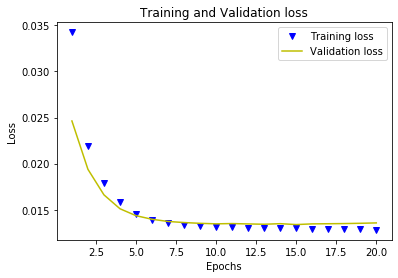

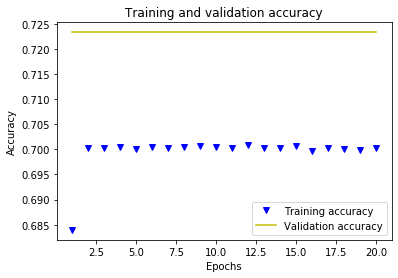

In [19]:
loss = caption_history.history['loss']
val_loss = caption_history.history['val_loss']
accuracy = caption_history.history['accuracy']
val_accuracy = caption_history.history['val_accuracy']

visualize(loss, val_loss, accuracy, val_accuracy)

## Prediction on Caption model<a class="anchor" id="pred1"></a>

In [20]:
predictions1 = caption_model.predict(X_test) 
Get_score(predictions1, Y_test)

The Spearman's correlation coefficient is: 0.403
The Spearman's correlation coefficient is: 0.198


## Cross_validation

## HMP Feature <a class="anchor" id="hmp"></a>
Reading HMP feature of each video and standardising it

In [21]:
def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

In [22]:
path = r"C:\Users\RANJAN DAS\Video memorability\Train_set\HMP\*.txt"

HMP_feature_list= []
video_names_list = []

for filename in glob.glob(path):
    name = ((filename.split('\\')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_feature_list.append(HMP_features)
    
np.array(HMP_feature_list).shape

(6000, 6075)

In [23]:
HMP_features = pd.DataFrame(np.array(HMP_feature_list).reshape(6000,6075))
HMP_features["video"] = video_names_list

In [24]:
#merging with the short term and long term score
pdf = pd.merge(df, HMP_features , on='video')
pdf.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,...,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video3,0.924,0.846,0.125563,0.024036,0.000314,0.0,0.015864,0.000358,0.0,...,0.000000,0.000393,0.000279,0.000000,0.000289,0.001926,0.000000,0.000086,0.000580,0.000000
1,video4,0.923,0.667,0.007526,0.001421,0.000068,0.0,0.001184,0.000143,0.0,...,0.000053,0.000244,0.000066,0.000000,0.000081,0.000617,0.000094,0.000220,0.000762,0.001224
2,video6,0.863,0.700,0.109584,0.018978,0.000289,0.0,0.008774,0.000208,0.0,...,0.000007,0.000054,0.000045,0.000000,0.000028,0.000291,0.000033,0.000052,0.000258,0.000215
3,video8,0.922,0.818,0.120431,0.013561,0.000277,0.0,0.018974,0.000913,0.0,...,0.000059,0.001110,0.000075,0.000008,0.000333,0.000793,0.000101,0.000588,0.000503,0.000452
4,video10,0.950,0.900,0.005026,0.001356,0.000055,0.0,0.000665,0.000029,0.0,...,0.000009,0.000882,0.000200,0.000009,0.000559,0.001097,0.000018,0.000632,0.001128,0.000064


In [25]:
X_train_hmp = pdf.iloc[:, 3:].values
Y_train_hmp = pdf.iloc[:, 1:3].values

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_hmp,Y_train_hmp, test_size=0.2, random_state=1)

## HMP model  creation<a class="anchor" id="hmpmod"></a>

In [27]:
def hmp_base_model():
    model = Sequential()
    model.add(layers.Dense(100, activation='selu', input_shape=(6075,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='selu',kernel_initializer='he_normal', kernel_constraint = maxnorm(5), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

hmp_model = hmp_base_model()
hmp_history = hmp_model.fit(X_train, Y_train, epochs=30, verbose=0, validation_data=(X_test,Y_test),shuffle=False)


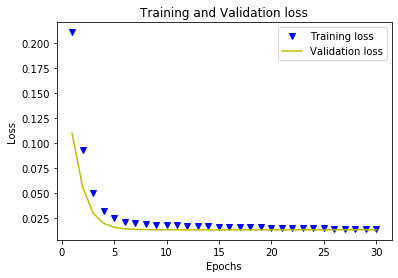

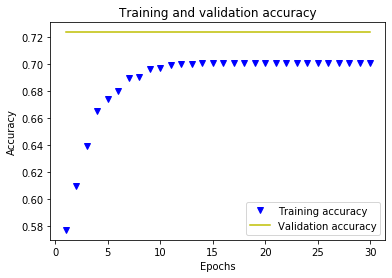

In [28]:
loss = hmp_history.history['loss']
val_loss = hmp_history.history['val_loss']
accuracy = hmp_history.history['accuracy']
val_accuracy = hmp_history.history['val_accuracy']

visualize(loss, val_loss, accuracy, val_accuracy)

## Predictions based on HMP feature<a class="anchor" id="pred2"></a>

In [29]:
predictions2 = hmp_model.predict(X_test)
print(predictions2)
Get_score(predictions2, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8621029  0.7833043 ]
 [0.88004524 0.8021418 ]
 [0.8475112  0.768003  ]
 ...
 [0.87075126 0.792512  ]
 [0.8593098  0.78030753]
 [0.82557935 0.7449188 ]]
The Spearman's correlation coefficient is: 0.283
The Spearman's correlation coefficient is: 0.151


## C3D Feature<a class="anchor" id="c3d"></a>

In [30]:
C3D_feature_list= []
video_names_list = []
path = r"C:\Users\RANJAN DAS\Video memorability\Train_set\C3D\*.txt"

for filename in glob.glob(path):
    name = ((filename.split('\\')[-1]).split('.')[0])
    video_names_list.append(name) 
    with open(filename) as f:
        for line in f:
            C3D_features =[float(item) for item in line.split()]
    C3D_feature_list.append(C3D_features)

In [31]:
C3D_features = pd.DataFrame(np.array(C3D_feature_list).reshape(6000,101))
C3D_features["video"] = video_names_list

cdf = pd.merge(df, C3D_features , on='video')
cdf.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
0,video3,0.924,0.846,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4,0.923,0.667,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6,0.863,0.700,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8,0.922,0.818,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10,0.950,0.900,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


Defining dependent and independent variables

In [32]:
X_train_c3d = cdf.iloc[:, 3:].values
Y_train_c3d = cdf.iloc[:, 1:3].values

X_train, X_test, Y_train, Y_test = train_test_split(X_train_c3d,Y_train_c3d, test_size=0.2, random_state=1)

## C3D Model<a class="anchor" id="c3dmod"></a>

In [33]:
def c3d_base_model():
    model = Sequential()
    model.add(layers.Dense(100, activation='selu', input_shape=(101,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='selu',kernel_initializer='he_normal', kernel_constraint = maxnorm(5), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    return model

c3d_model = c3d_base_model()
c3d_history = c3d_model.fit(X_train, Y_train, epochs=25, verbose=0, validation_data=(X_test,Y_test),shuffle=False)

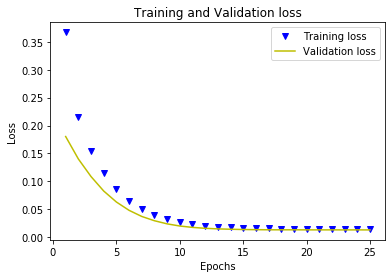

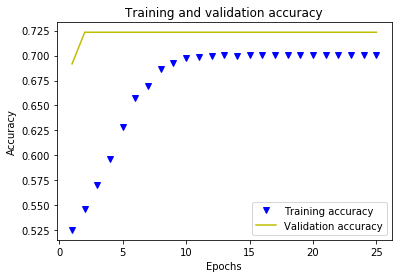

In [34]:
loss = c3d_history.history['loss']
val_loss = c3d_history.history['val_loss']
accuracy = c3d_history.history['accuracy']
val_accuracy = c3d_history.history['val_accuracy']

visualize(loss, val_loss, accuracy, val_accuracy)

## Prediction on C3D Model<a class="anchor" id="pred3"></a>

In [35]:
predictions3 = c3d_model.predict(X_test)
print(predictions3)
Get_score(predictions3, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8742594  0.7959492 ]
 [0.8800133  0.80339444]
 [0.8519015  0.7696104 ]
 ...
 [0.83036923 0.756135  ]
 [0.86373925 0.7889121 ]
 [0.8391799  0.76350856]]
The Spearman's correlation coefficient is: 0.357
The Spearman's correlation coefficient is: 0.151


## Ensemble 1<a class="anchor" id="ensemble1"></a>

In [36]:
predictions_weighted  = 0.34*predictions1 + 0.33*predictions2 + 0.33*predictions3

In [37]:
#pred_out = model.predict(X_test)
print(predictions_weighted)
Get_score(predictions_weighted, Y_test) # Try remember what the Spearman scores actually mean!

[[0.87054044 0.79368544]
 [0.8738723  0.7975466 ]
 [0.85408044 0.77249837]
 ...
 [0.84520024 0.76207215]
 [0.86166775 0.785985  ]
 [0.8411261  0.76610583]]
The Spearman's correlation coefficient is: 0.432
The Spearman's correlation coefficient is: 0.222


## Combined Model<a class="anchor" id="combmod"></a>
A sequential network created by using HMP, C3D and Camptions as input to the model

In [38]:
datafm = np.concatenate((X_cap,X_train_c3d,X_train_hmp),axis=1)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(datafm,Y_cap, test_size=0.2, random_state=1)
                                                    
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 11367)
X_test (1200, 11367)
Y_train (4800, 2)
Y_test (1200, 2)


In [40]:
def test_model():
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(11367,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal', kernel_constraint = maxnorm(5)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    sgd = tf.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy']) 
 
    return model
            
test1_model = test_model()
test1_history = test1_model.fit(X_train, Y_train, epochs=20, verbose=0, validation_data=(X_test,Y_test),shuffle=False)

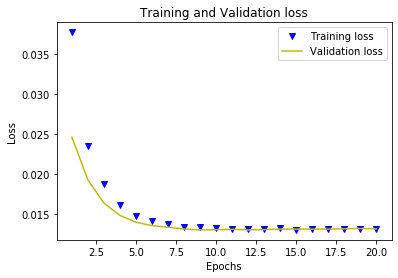

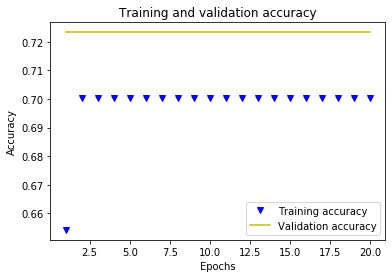

In [41]:
loss = test1_history.history['loss']
val_loss = test1_history.history['val_loss']
accuracy = test1_history.history['accuracy']
val_accuracy = test1_history.history['val_accuracy']

visualize(loss, val_loss, accuracy, val_accuracy)

In [42]:
from sklearn.model_selection import learning_curve

def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2


def draw_learning_curves(X, Y, estimator, num_trainings):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, Y, cv=None, n_jobs=-1, 
                                                            train_sizes=np.linspace(0.1, 1.0, 
                                                                                    num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training instances")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


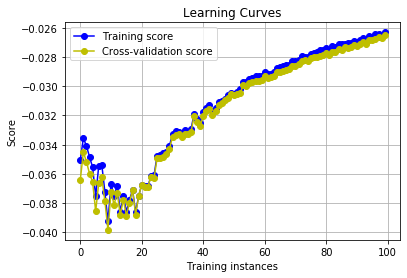

In [43]:
model = KerasRegressor(build_fn=test_model, verbose=0)

X_LC, Y_LC = randomize(X_train, Y_train) 

draw_learning_curves(X_LC, Y_LC, estimator=model, num_trainings=100)

## Predictions<a class="anchor" id="pred4"></a>

In [44]:
test_predictions = test1_model.predict(X_test)
print(test_predictions)
Get_score(test_predictions, Y_test)

[[0.8652962  0.78800493]
 [0.87073874 0.7954724 ]
 [0.8615942  0.78389126]
 ...
 [0.8229481  0.73721015]
 [0.8637969  0.79059035]
 [0.85039985 0.7694409 ]]
The Spearman's correlation coefficient is: 0.421
The Spearman's correlation coefficient is: 0.231


## Ensemble 2<a class="anchor" id="ensemble2"></a>

In [45]:
predictions_weighted_final  = 0.25*predictions1 + 0.25*predictions2 + 0.25*predictions3 + 0.25*test_predictions
print(predictions_weighted_final)
Get_score(predictions_weighted_final, Y_test)

[[0.8691947  0.79220563]
 [0.87317944 0.7971049 ]
 [0.85589457 0.7752922 ]
 ...
 [0.83971596 0.75603676]
 [0.86219794 0.7871161 ]
 [0.84331584 0.7667647 ]]
The Spearman's correlation coefficient is: 0.443
The Spearman's correlation coefficient is: 0.233


# Test data<a class="anchor" id="test"></a>

## Caption model<a class="anchor" id="captest"></a>

In [46]:
frames1 = [df, df1]
result1 = pd.concat(frames1)

frames = [captions_features, captions_features_test]
result = pd.concat(frames)

In [47]:
result.reset_index(drop=True, inplace=True)
result1.reset_index(drop=True, inplace=True)

In [48]:
counts1 = Counter()
pbar = pyprind.ProgBar(len(result['Captions']), title='Counting word occurrences')


for i, cap in enumerate(result['Captions']):
        # replace punctuations with space
        # convert words to lower case 
        text1 = ''.join([c if c not in punctuation else ' ' for c in cap]).lower() 
        result.loc[i,'Captions'] = text1
        # .loc[,]: Access a group of rows and columns by label(s)
        
        pbar.update()
        counts1.update(text1.split())

counts1.most_common

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


<bound method Counter.most_common of Counter({'in': 2800, 'the': 2411, 'on': 2304, 'and': 1913, 'a': 1577, 'with': 1327, 'woman': 1202, 'of': 1143, 'at': 987, 'young': 957, 'man': 725, 'slow': 628, 'motion': 568, 'to': 560, 'couple': 424, 'girl': 399, 'sitting': 399, 'happy': 364, 'up': 352, 'park': 341, 'beach': 340, 'walking': 313, 'close': 312, 'camera': 300, 'shot': 292, 'her': 286, 'using': 283, 'smiling': 263, 'looking': 261, 'by': 253, 'is': 249, 'two': 244, 'people': 244, 'tablet': 242, 'from': 233, 'water': 224, 'through': 209, 'view': 203, 'computer': 196, 'female': 195, 'talking': 186, 'sunset': 186, 'videoblocks': 184, 'working': 180, 'beautiful': 179, 'laptop': 176, 'playing': 175, 'city': 175, 'running': 172, 'for': 169, 'his': 168, 'little': 168, 'eating': 167, 'family': 164, 'background': 156, 'mother': 154, 'or': 152, 'phone': 151, 'tree': 148, 'home': 147, 'national': 142, 'standing': 142, 'hands': 140, 'sea': 140, 'african': 138, 'their': 136, 'drinking': 135, 'snow'

In [49]:
t = Tokenizer(num_words=len(counts1)) 
t.fit_on_texts(list(result.Captions.values)) 
onehot = t.texts_to_matrix(list(result.Captions.values),mode='binary')

In [50]:
Y = result1[['short-term_memorability','long-term_memorability']].values # targets
X = onehot;
print(Y.shape,X.shape)

(8000, 2) (8000, 5870)


In [51]:
x_train = X[:6000,:]
x_test = X[6000:,:]
y_train = Y[:6000,:]
y_test = Y[6000:,:]

print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (6000, 5870)
x_test (2000, 5870)
y_train (6000, 2)
y_test (2000, 2)


In [52]:
len_token_test = len(counts1)
def caption_test_model():
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(len_token_test,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal'))
    model.add(layers.Dense(2, activation='sigmoid'))
    sgd = tf.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy']) 
 
    return model
            
cap_model_test = caption_test_model()
cap_model_test_history = cap_model_test.fit(x_train, y_train, epochs=20, verbose=0,shuffle=False)

## Predictions

In [53]:
test_predictions1 = cap_model_test.predict(x_test) 
test_predictions1

array([[0.82801425, 0.7563994 ],
       [0.7780976 , 0.73407596],
       [0.89121646, 0.811397  ],
       ...,
       [0.86959606, 0.7976343 ],
       [0.87009335, 0.80107707],
       [0.88791347, 0.82317245]], dtype=float32)

## HMP model<a class="anchor" id="hmptest"></a>

In [54]:
path = r"C:\Users\RANJAN DAS\Video memorability\Test_set\HMP_test\*.txt"

HMP_test_feature_list= []
video_names_list = []

for filename in glob.glob(path):
    name = ((filename.split('\\')[-1]).split('.')[0])
    video_names_list.append(name)
    HMP_features = read_HMP(filename)
    HMP_test_feature_list.append(HMP_features)
    
np.array(HMP_test_feature_list).shape

(2000, 6075)

In [55]:
HMP_test_features = pd.DataFrame(np.array(HMP_test_feature_list).reshape(2000,6075))
HMP_test_features["video"] = video_names_list

In [56]:
#merging with the short term and long term score
hmp = pd.merge(df1, HMP_test_features , on='video')
hmp.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,...,6065,6066,6067,6068,6069,6070,6071,6072,6073,6074
0,video7494,NaN,NaN,0.022039,0.005264,0.000098,0.0,0.003689,0.000129,0.0,...,0.000025,0.000114,0.000056,0.000002,0.000136,0.000388,0.000038,0.000165,0.000488,0.000187
1,video7495,NaN,NaN,0.004694,0.001934,0.000040,0.0,0.001226,0.000058,0.0,...,0.000000,0.000056,0.000027,0.000002,0.000087,0.000121,0.000004,0.000109,0.000136,0.000029
2,video7496,NaN,NaN,0.026530,0.006208,0.000058,0.0,0.002280,0.000031,0.0,...,0.000011,0.000034,0.000011,0.000002,0.000063,0.000081,0.000004,0.000092,0.000143,0.000051
3,video7497,NaN,NaN,0.045109,0.008317,0.000151,0.0,0.005598,0.000128,0.0,...,0.000035,0.000256,0.000083,0.000003,0.000116,0.000467,0.000020,0.000279,0.000470,0.000219
4,video7498,NaN,NaN,0.034691,0.008619,0.000412,0.0,0.028355,0.000538,0.0,...,0.000009,0.000148,0.000038,0.000002,0.000117,0.000206,0.000022,0.000228,0.000334,0.000086


In [57]:
X_test_hmp = hmp.iloc[:, 3:].values
Y_test_hmp = hmp.iloc[:, 1:3].values

print('x_train', X_train_hmp.shape)
print('x_test', X_test_hmp.shape)
print('y_train', Y_train_hmp.shape)
print('y_test', Y_test_hmp.shape)

x_train (6000, 6075)
x_test (2000, 6075)
y_train (6000, 2)
y_test (2000, 2)


## Predictions

In [58]:
hmp_test_model = hmp_base_model()
hmp_test_model_history = hmp_test_model.fit(X_train_hmp, Y_train_hmp, epochs=30, verbose=0, shuffle=False)
test_predictions2 = hmp_test_model.predict(X_test_hmp)
print(test_predictions2)

[[0.8390079  0.75560415]
 [0.8644286  0.7836125 ]
 [0.8948912  0.8170424 ]
 ...
 [0.87400997 0.79407966]
 [0.8432591  0.76040334]
 [0.87370336 0.79380774]]


## C3D model<a class="anchor" id="c3dtest"></a>

In [59]:
C3D_test_feature_list= []
video_names_list = []
path = r"C:\Users\RANJAN DAS\Video memorability\Test_set\C3D_test\*.txt"

for filename in glob.glob(path):
    name = ((filename.split('\\')[-1]).split('.')[0])
    video_names_list.append(name) 
    with open(filename) as f:
        for line in f:
            C3D_features =[float(item) for item in line.split()]
    C3D_test_feature_list.append(C3D_features)

np.array(C3D_test_feature_list).shape

(2000, 101)

In [60]:
C3D_test_features = pd.DataFrame(np.array(C3D_test_feature_list).reshape(2000,101))
C3D_test_features["video"] = video_names_list

c3d = pd.merge(df1, C3D_test_features , on='video')
c3d.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,...,91,92,93,94,95,96,97,98,99,100
0,video7494,NaN,NaN,0.000136,0.000213,0.001248,0.000011,1.180000e-06,4.276000e-05,5.800000e-07,...,0.000003,5.620000e-06,1.260000e-06,0.000199,1.500000e-06,2.000000e-07,5.840000e-06,0.000006,0.000210,0.195120
1,video7495,NaN,NaN,0.000127,0.000024,0.049501,0.000024,2.361000e-05,3.440000e-06,5.102000e-05,...,0.000173,3.019200e-04,2.649800e-04,0.000163,1.050000e-05,2.540000e-06,3.619300e-04,0.000016,0.000010,0.000392
2,video7496,NaN,NaN,0.488982,0.000585,0.000025,0.000160,2.400000e-07,8.300000e-07,3.620000e-06,...,0.000002,1.900000e-07,3.200000e-07,0.001802,2.640000e-06,9.000000e-08,2.600000e-07,0.000067,0.000123,0.000015
3,video7497,NaN,NaN,0.249251,0.001018,0.000008,0.000019,2.200000e-07,8.800000e-07,1.646560e-02,...,0.000065,8.400000e-07,1.700000e-07,0.000808,9.700000e-07,7.670000e-06,9.100000e-07,0.000015,0.000707,0.000010
4,video7498,NaN,NaN,0.009894,0.000034,0.002613,0.000002,1.010000e-06,8.770000e-06,2.610000e-06,...,0.000012,6.600000e-07,8.770000e-06,0.000132,7.400000e-07,2.120000e-06,8.260000e-06,0.001402,0.000745,0.000456


In [61]:
X_test_c3d = c3d.iloc[:, 3:].values
Y_test_c3d = c3d.iloc[:, 1:3].values

print('x_train', X_train_c3d.shape)
print('x_test', X_test_c3d.shape)
print('y_train', Y_train_c3d.shape)
print('y_test', Y_test_c3d.shape)

x_train (6000, 101)
x_test (2000, 101)
y_train (6000, 2)
y_test (2000, 2)


## Predictions

In [62]:
c3d_test_model = c3d_base_model()
c3d_test_model_history = c3d_test_model.fit(X_train_c3d, Y_train_c3d, epochs=30, verbose=0, shuffle=False)

test_predictions3 = c3d_test_model.predict(X_test_c3d)
print(test_predictions3)

[[0.8663644  0.78840405]
 [0.82471895 0.74542767]
 [0.8761934  0.7975647 ]
 ...
 [0.8837439  0.804978  ]
 [0.8351842  0.75685906]
 [0.9029144  0.8273722 ]]


# Combined model<a class="anchor" id="combtest"></a>

In [63]:
test_cap_x = onehot[:6000,]
test_cap_y = onehot[6000:,]
test_cap_y, test_cap_x

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]))

In [64]:
X_data_ens_train = np.concatenate((test_cap_x,X_train_c3d,X_train_hmp),axis=1)
X_data_ens_test = np.concatenate((test_cap_y,X_test_c3d,X_test_hmp),axis=1)
Y_ens_train = Y_train_c3d

In [65]:
print('X train', X_data_ens_train.shape)
print('X train', X_data_ens_test.shape)
print('Y train', Y_ens_train.shape)

X train (6000, 12046)
X train (2000, 12046)
Y train (6000, 2)


In [66]:
def ensemble_model():
    model = Sequential()
    model.add(layers.Dropout(0.3, input_shape=(12046,)))
    model.add(layers.Dense(10, activation='selu', kernel_regularizer=regularizers.l2(0.001),
                         kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    sgd = tf.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(optimizer=sgd, loss='mse', metrics=['accuracy']) 
 
    return model
            
ensemble_model_final = ensemble_model()
ensemble_model_history = ensemble_model_final.fit(X_data_ens_train, Y_ens_train, epochs=20, verbose=0, shuffle=False)

## Predictions

In [67]:
test_predictions4 = ensemble_model_final.predict(X_data_ens_test)
print(test_predictions4)

[[0.84549534 0.7592391 ]
 [0.7897245  0.71709394]
 [0.88372123 0.8108029 ]
 ...
 [0.86766195 0.7718884 ]
 [0.8722212  0.8092892 ]
 [0.8954007  0.83040756]]


## Final Submission<a class="anchor" id="finsub"></a>

In [68]:
Final_submission  = 0.25*test_predictions1 + 0.25*test_predictions2 + 0.25*test_predictions3 + 0.25*test_predictions4 
Final_submission

array([[0.8447205 , 0.76491165],
       [0.8142424 , 0.7450525 ],
       [0.8865056 , 0.8092018 ],
       ...,
       [0.87375295, 0.792145  ],
       [0.8551895 , 0.78190714],
       [0.889983  , 0.81869   ]], dtype=float32)

In [69]:
final_submission_file = pd.read_csv(r'C:\Users\RANJAN DAS\Video memorability\Test_set\Ground-truth_test\ground_truth_template.csv')
final_submission_file.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [70]:
final_submission_file['short-term_memorability'] = Final_submission[:, :1]
final_submission_file['long-term_memorability'] = Final_submission[:, 1:]

In [71]:
final_submission_file.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.844720,33,0.764912,12
1,7495,0.814242,34,0.745053,10
2,7496,0.886506,32,0.809202,13
3,7497,0.866974,33,0.789615,10
4,7498,0.839391,33,0.749889,10


In [72]:
final_submission_file.shape

(2000, 5)

In [73]:
final_submission_file.to_csv(r'C:\Users\RANJAN DAS\Machine learning assignment\final_submission.csv')